In [20]:
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (25, 10)

Populating the interactive namespace from numpy and matplotlib


In [21]:
import pandas as pd
import os, sys

In [22]:
tweet_dir = 'tweets_raw'
full_tweets = os.getcwd() + os.sep + tweet_dir
files = os.listdir(full_tweets)

In [23]:
# grab the first 99 tweets
df = pd.DataFrame()
df2 = pd.read_csv(full_tweets + os.sep + 'tweets_lang_99.csv', sep='\t', header=None)

In [24]:
df.append(df2).head()

,0,1
0,إضغط على منطقتك يتبين لك كم يتبقى من الوقت عن ...,ar
1,اللَّهٌمَّ صَلِّ وَسَلِّمْ عَلىٰ نَبِيِّنَآ مُ...,ar
2,@lliiilx تم,ar
3,@Dinaa_ElAraby اها يا بيبي والله اتهرست علي تو...,ar
4,• افضل كتاب قرأته هو : أمي (ابراهام لنكولن)🌹�...,ar


Now we can clearly see that tweets are problematic in terms of languages. Not only do we need to deal with non-alphanumeric characters, we also have to remove part-alphanumerics, like mentions, hashtags and others. We can't remove specific character sets either. We can also look at the list of character ranges for emoticons here: http://apps.timwhitlock.info/emoji/tables/unicode. Most of them start with \xE or \xF so we could use that to clean up the strings more. So we'll start by implementing some filters. Below is a very hacky way of removing these basic things. 

In [25]:
import re
mention_patt = r'(\@\w*)'
hash_patt = r'(\#\w*)'
url_patt = r'(http[s?]\:\/\/.*\s)'
emotic_patt = r'(\s+[\xe0-\xf0].+\s+)'
test = "@Dinaa_ElAraby اها يا بيبي والله اتهرست علي تويتر و ع #keek some english https://t.co/vOR/aVpTnJ9?q=b  🌹🌹🌹🌹 text"
print "Before: ", test
replaced = re.sub(mention_patt, '', test)
print "After mention replacement:\t", replaced
replaced = re.sub(hash_patt, '', replaced)
print "After hashtag replacement:\t", replaced
replaced = re.sub(url_patt, '', replaced)
print "After url replacement:\t", replaced
replaced = re.sub(emotic_patt, '', replaced)
print "After emoticon replacement:\t", replaced

Before:  @Dinaa_ElAraby اها يا بيبي والله اتهرست علي تويتر و ع #keek some english https://t.co/vOR/aVpTnJ9?q=b  🌹🌹🌹🌹 text
After mention replacement:	 اها يا بيبي والله اتهرست علي تويتر و ع #keek some english https://t.co/vOR/aVpTnJ9?q=b  🌹🌹🌹🌹 text
After hashtag replacement:	 اها يا بيبي والله اتهرست علي تويتر و ع  some english https://t.co/vOR/aVpTnJ9?q=b  🌹🌹🌹🌹 text
After url replacement:	 اها يا بيبي والله اتهرست علي تويتر و ع  some english text
After emoticon replacement:	 اها يا بيبي والله اتهرست علي تويتر و ع  some english text


Now we can read in every CSV file, clean every tweet and load everything in to CSV. 

In [26]:
all_tweets = pd.read_csv('tweets_collected.tsv', sep='\t')
all_tweets.count(axis=0)

Unnamed: 0    88470
tweet         88321
lang          88425
dtype: int64

This is strange and worrying. We have an extra column -- probably from the CSV files' index numbers -- and our tweets and languages numbers don't match up. What's probably happened is that we have some corrupted tweets, and some corrupted languages. Thankfully their numbers are small enough to (hopefully) not make a huge difference to our dataset. 

In [27]:
all_tweets.head()

,Unnamed: 0,tweet,lang
0,69,"As oportunidades nunca são perdidas, alguém va...",pt
1,70,voltei rs,pt
2,71,É tão bom falar sozinho neste site,pt
3,72,Nossa malhei hoje de mais to completamente morta,pt
4,73,Estou com saudades das minhas amigas Kassiane ...,pt


Now we count the rows where tweet or language is null. We find that the "unnamed" column is actually equal to the null tweets + null languages. 

In [28]:
all_tweets.loc[all_tweets['tweet'].isnull() | 
              all_tweets['lang'].isnull()].count()

Unnamed: 0    194
tweet          45
lang          149
dtype: int64

We can now drop all the nulls and check again to see if the languages and tweets add up. 

In [29]:
nona_all_tweets = all_tweets.dropna()

In [30]:
nona_all_tweets.count()

Unnamed: 0    88276
tweet         88276
lang          88276
dtype: int64

In [31]:
tweet_data = nona_all_tweets.drop(nona_all_tweets.columns[0], axis=1)

We just dropped the extra column and arranged everything so we can see our data more accurately. 

In [32]:
tweet_data.head()

,tweet,lang
0,"As oportunidades nunca são perdidas, alguém va...",pt
1,voltei rs,pt
2,É tão bom falar sozinho neste site,pt
3,Nossa malhei hoje de mais to completamente morta,pt
4,Estou com saudades das minhas amigas Kassiane ...,pt


In [33]:
tweet_data.loc[tweet_data['lang'] == 'und'].count()

tweet    7032
lang     7032
dtype: int64

The problem now is that we have a lot of tweets which can't be characterized into a specific language. Fine, we can live with that for now and treat "und" as a class. 

In [34]:
import seaborn as sb

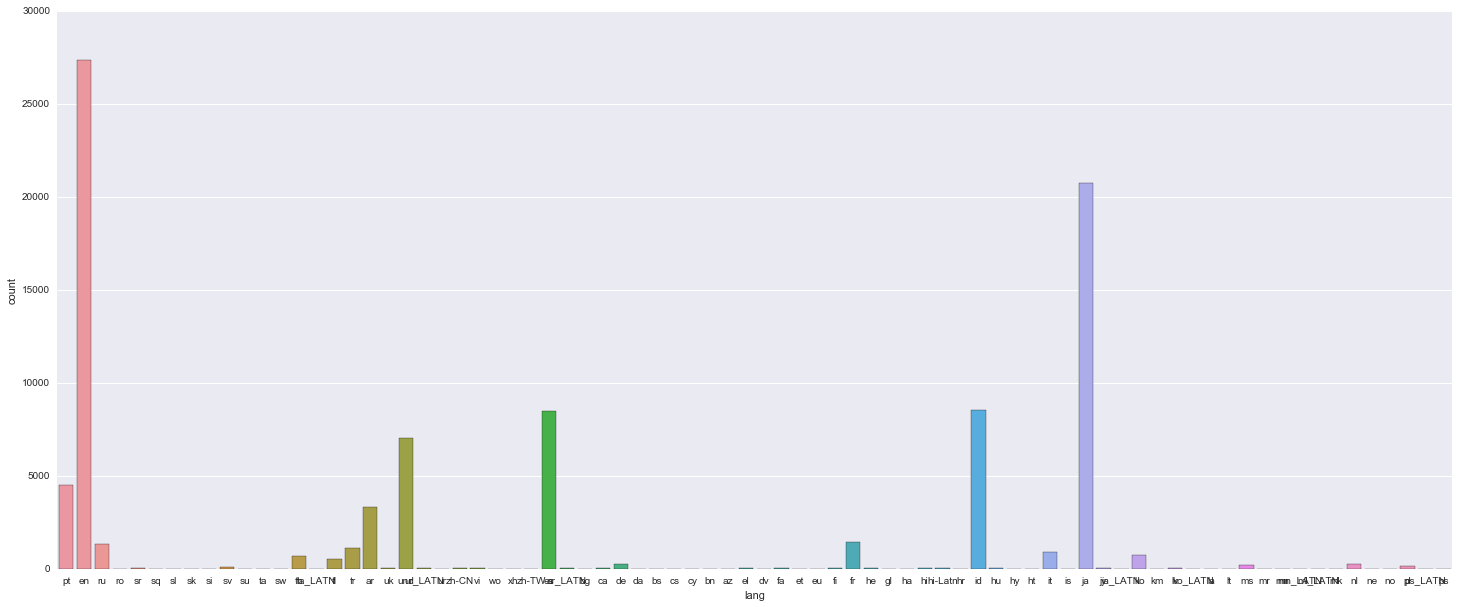

In [35]:
sb.countplot(x='lang', data=tweet_data)

Now that we've done a lot of clean up -- dropped N/A rows (could be because of corrupted downloads) and removed our unnecessary column (probably the index from the smaller CSV files) -- we can actually move on to processing the data. 